## 四跨连续箱梁桥 OpenSeesPy 建模 Notebook



## 参数设置

In [23]:
deck_width = 15   #桥面宽度
nodes_per_span = 7 #每跨桥面节点数量


num_spans = 3    #跨数
span_length = 20  #每跨宽度
cols_per_pier = 2  #每墩柱子数量
nodes_per_col = 8  #每柱节点数量
col_height = 8.0   #柱高
edge_clear = 1.5   #桥面挑宽


abut_nodes = 8  #桥台节点数量

### 建立 OpenSeesPy 域并设定单位

In [24]:
import openseespy.opensees as ops
import opsvis as opsv
import opstool as opst
import opstool.vis.plotly as opsvis
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)
units = {"length": "m", "force": "N", "mass": "kg"}


### 节点

In [25]:
#桥墩节点
def define_pier_nodes(num_spans: int,
                      span_length: float,
                      cols_per_pier: int,
                      nodes_per_col: int,
                      col_height: float,
                      deck_width: float,
                      edge_clear: float,
                      start_tag: int = 1):
    """
    坐标与几何：
    1) 桥轴线取 x，中间一共 num_spans-1 个桥墩，分别位于
         x_pier = (s+1)*span_length,  s = 0..num_spans-2
    2) 同一桥墩内多根墩柱沿 y 等距布置，左右对称，外侧离桥面边缘保留 edge_clear：
         有效宽度 We = deck_width - 2*edge_clear
         若 cols_per_pier == 1: 仅一根柱，y = 0
         若 cols_per_pier >= 2: y 从 -We/2 到 +We/2 线性分布
    3) 墩柱高 H = col_height。沿 z 从 0 到 H 等分：
         z_k = k * (H/(nodes_per_col-1))，k = 0..nodes_per_col-1。

    参数
    ----
    num_spans     : 跨数（正整数，>=2）
    span_length   : 跨距
    cols_per_pier : 每跨墩柱根数（正整数）
    nodes_per_col : 每根墩柱的节点数（≥2，含顶、底）
    col_height    : 柱高 H
    deck_width    : 桥面总宽度
    edge_clear    : 墩柱外排中心距桥面边缘的横向净距

    返回
    ----
    dict:
      "pier_nodes": [pier][col][level] -> nodeTag
      "coords":     {nodeTag: (x, y, z)}
      "next_tag":   下一个可用节点号
    """
    coords = {}
    pier_nodes = []

    dz = float(col_height) / (nodes_per_col - 1)

    # 计算横向布置
    if cols_per_pier == 1:
        y_list = [0.0]
    else:
        We = float(deck_width) - 2.0 * float(edge_clear)
        if We <= 0.0:
            raise ValueError("deck_width - 2*edge_clear 必须为正，用于布置多根墩柱。")
        dy = We / float(cols_per_pier - 1)
        y_list = [-We / 2.0 + i * dy for i in range(cols_per_pier)]

    # 中间一共 num_spans-1 个桥墩，分别在 x = L, 2L, ..., (num_spans-1)*L
    for s in range(num_spans - 1):
        x = (s + 1) * float(span_length)

        cols = []
        for c in range(cols_per_pier):
            y = y_list[c]

            levels = []
            for k in range(nodes_per_col):
                z = k * dz
                ops.node(start_tag, x, y, z)
                coords[start_tag] = (x, y, z)
                levels.append(start_tag)
                start_tag += 1
            cols.append(levels)
        pier_nodes.append(cols)

    return {"pier_nodes": pier_nodes, "coords": coords, "next_tag": start_tag}


#桥面主梁节点
def define_deck_nodes(num_spans: int,
                      span_length: float,
                      nodes_per_span: int,
                      col_height: float,
                      start_tag = 1000):
    """
    定义桥面（梁）节点；编号从 1000 连续递增。
    布置原则：
      1) 节点位于 y=0，z=col_height。
      2) 每跨等分为 nodes_per_span 个节点，包含两端点。
      3) 为避免跨间重复，从第二跨起不重复左端点。
    参数
      num_spans       : 跨数（正整数）
      span_length     : 跨距
      nodes_per_span  : 一跨内节点数量（≥2，含两端）
      col_height      : 柱高；亦可传入“柱高+所需竖向偏置”
    返回
      dict:
        "deck_nodes": [span][i] -> nodeTag
        "coords":     {nodeTag: (x, y, z)}
        "next_tag":   下一个可用节点号
    """
    coords = {}
    deck_nodes = []

    dx = float(span_length) / (nodes_per_span - 1)
    z  = float(col_height)

    for s in range(num_spans):
        x0 = s * float(span_length)
        span_tags = []
        k_start = 0 if s == 0 else 1  # 避免跨界重复
        for k in range(k_start, nodes_per_span):
            x = x0 + k * dx
            ops.node(start_tag, x, 0.0, z)
            coords[start_tag] = (x, 0.0, z)
            span_tags.append(start_tag)
            start_tag += 1
        deck_nodes.append(span_tags)

    return {"deck_nodes": deck_nodes, "coords": coords, "next_tag": start_tag}

#桥台节点
def define_abutment_nodes(deck_res: list,
                          n: int,
                          total_y: float,
                          start_tag: int = 2000):
    """
    按总长 total_y 与数量 n 在 y 向均匀布置节点。
    返回 {"left": [tags...], "right": [tags...], "next_tag": ...}
    """
    left_node  = deck_res["deck_nodes"][0][0]
    right_node = deck_res["deck_nodes"][-1][-1]
    xL, _, zL = ops.nodeCoord(left_node)
    xR, _, zR = ops.nodeCoord(right_node)

    def _ys(total_len: float, npts: int):
        if npts == 1:
            return [0.0]
        dy = total_len / (npts - 1)
        y0 = -total_len / 2.0
        return [y0 + i * dy for i in range(npts)]

    ys = _ys(float(total_y), int(n))

    left_tags = []
    for y in ys:
        ops.node(start_tag, xL, y, zL)
        left_tags.append(start_tag)
        start_tag += 1

    right_tags = []
    for y in ys:
        ops.node(start_tag, xR, y, zR)
        right_tags.append(start_tag)
        start_tag += 1

    return {"left": left_tags, "right": right_tags, "next_tag": start_tag}

#盖梁节点
def define_capbeam_nodes(pier_nodes, start_tag=3000):
    t = int(start_tag)
    cap, centers = [], []
    for pier in pier_nodes:
        coords = [ops.nodeCoord(col[-1]) for col in pier]
        tags = []
        for x, y, z in coords:
            ops.node(t, x, y, z); tags.append(t); t += 1
        x0 = sum(c[0] for c in coords)/len(coords)
        z0 = sum(c[2] for c in coords)/len(coords)
        ops.node(t, x0, 0.0, z0); centers.append(t); t += 1
        cap.append(tags)
    return {"capbeam_nodes": cap, "capbeam_center_nodes": centers}


In [26]:
pier_res = define_pier_nodes(num_spans=num_spans,
                        span_length=span_length,
                        cols_per_pier=cols_per_pier,
                        nodes_per_col=nodes_per_col,
                        col_height=col_height,
                        deck_width=deck_width,
                        edge_clear=edge_clear)

deck_res = define_deck_nodes(num_spans=num_spans,
                            span_length=span_length,
                            nodes_per_span=nodes_per_span,
                            col_height=col_height)

capbeam_res = define_capbeam_nodes(pier_res["pier_nodes"])


# abut_res= define_abutment_nodes(deck_res,
#                                 abut_nodes,
#                                 deck_width)

# opsvis.plot_model()

# 盖梁中心节点只承担刚性连接与集中质量，锁定转动自由度避免自由转动导致奇异质量矩阵
for center_tag in capbeam_res["capbeam_center_nodes"]:
    ops.fix(center_tag, 0, 0, 0, 1, 1, 1)

## 材料定义

In [27]:
mat_core  = 1
mat_cover = 2
mat_steel = 3
mat_bearing_ver = 4
mat_bearing_tran = 5
mat_reverse = 6
mat_soil = 7
mat_deck_abut = 8
shear_key = 9

ops.uniaxialMaterial('Concrete02', mat_core,  -40e6, -0.0025, -25e6, -0.02, 0.1, 2.0e6, 200e6)
ops.uniaxialMaterial('Concrete02', mat_cover, -30e6, -0.0020, -20e6, -0.0035, 0.1, 1.5e6, 150e6)
ops.uniaxialMaterial('Steel02',    mat_steel, 420e6, 2.0e11, 0.01, 20.0, 0.925, 0.15)

ops.uniaxialMaterial('Elastic',    mat_bearing_ver, 2.0e8)
ops.uniaxialMaterial('ElasticPP',    mat_bearing_tran, 2.0e5 , 0.002)
ops.uniaxialMaterial('Elastic',    mat_reverse, 1.0e9)
ops.uniaxialMaterial('ElasticPPGap',    mat_soil, 5.0e4, -5000.0, -0.03)
ops.uniaxialMaterial('ElasticPPGap',    mat_deck_abut, 1.0e7, -1.0e8, -0.05)
ops.uniaxialMaterial('ElasticPPGap',    shear_key,  2.0e8, 6.0e5, 0.02)

## 截面定义

In [28]:
# -*- coding: utf-8 -*-
import math

def fiber_section(
    section_tag: int,
    diameter: float,
    cover: float,
    n_bars: int,
    rho_s: float,           # 配筋率（纵筋总面积/核心混凝土面积）
    torsion_GJ: float,
    mat_core: int,          # Concrete02（核心）
    mat_cover: int,         # Concrete02（保护层）
    mat_steel: int,         # Steel02（纵筋）
    mesh_size: float | None = None,
    show_mesh: bool = True,
    aucuracy_mesh: bool = True,  # True: opstool 精细网格；False: OpenSeesPy 简易划分
    plot_section: bool = True
):
    """
    圆形 RC 纤维截面。钢筋直径依据配筋率计算：
      A_core   = π * core_radius^2
      As_total = rho_s * A_core
      A_bar    = As_total / n_bars
      d_bar    = sqrt(4*A_bar/π)
    aucuracy_mesh=True 时，用 opstool 生成并网格剖分；否则用 OpenSeesPy 的 patch/layer 简易离散。
    """
    # 几何
    radius = 0.5 * float(diameter)
    core_radius = radius - float(cover)

    # 依据配筋率计算钢筋参数
    A_core = math.pi * core_radius * core_radius
    As_total = float(rho_s) * A_core
    A_bar = As_total / int(n_bars)
    bar_d = math.sqrt(4.0 * A_bar / math.pi)

    if aucuracy_mesh:
        # opstool 精细网格
        hole = opst.pre.section.create_circle_points([0.0, 0.0], core_radius, n_sub=96)
        cover_annulus = opst.pre.section.create_circle_patch([0.0, 0.0], radius, holes=[hole], n_sub=96)
        core_solid = opst.pre.section.create_circle_patch([0.0, 0.0], core_radius, n_sub=96)

        SEC = opst.pre.section.FiberSecMesh(sec_name=f"RC circular secTag={section_tag}")
        SEC.add_patch_group({"cover": cover_annulus, "core": core_solid})

        h = (mesh_size if (mesh_size and mesh_size > 0) else radius / 12.0)
        SEC.set_mesh_size({"cover": h, "core": h})
        SEC.set_ops_mat_tag({"cover": mat_cover, "core": mat_core})

        # 环向配筋（按配筋率反算直径）
        rebar_pts = opst.pre.section.create_circle_points([0.0, 0.0], core_radius, n_sub=int(n_bars))
        SEC.add_rebar_line(points=rebar_pts, dia=bar_d, n=int(n_bars),
                           ops_mat_tag=mat_steel, group_name="RebarRing")

        # 划分与查看
        SEC.mesh()
        SEC.centring()
        if show_mesh:
            SEC.view()

        # 写入 OpenSees（真实 Fiber 截面）
        SEC.to_opspy_cmds(secTag=int(section_tag), GJ=float(torsion_GJ))

        mesh_info = {"mesh_mode": "opstool", "mesh_size": h}
    else:
        # OpenSeesPy 简易划分（原生命令 patch/layer）
        ops.section('Fiber', int(section_tag), '-GJ', float(torsion_GJ))

        # 保护层环：外半径 radius，内半径 core_radius
        # 参数：matTag, numSubdivRad, numSubdivCirc, yC, zC, ri, ro, angStart, angEnd
        ops.patch('circ', int(mat_cover), 20,3, 0.0, 0.0, core_radius, radius, 0.0, 360.0)

        # 核心混凝土：内半径 0，外半径 core_radius
        ops.patch('circ', int(mat_core), 20,12, 0.0, 0.0, 0.0, core_radius, 0.0, 360.0)

        # 环向钢筋：numBars, areaFiber, yC, zC, r, angStart, angEnd
        ops.layer('circ', int(mat_steel), n_bars, A_bar, 0.0, 0.0, core_radius, 0.0, 360.0)
        
        fib_sec = [
        ['section', 'Fiber', int(section_tag), '-GJ', float(torsion_GJ)],
        ['patch', 'circ', int(mat_cover), 20,3, 0.0, 0.0, core_radius, radius, 0.0, 360.0],
        ['patch', 'circ', int(mat_core), 20,12, 0.0, 0.0, 0.0, core_radius, 0.0, 360.0],
        ['layer', 'circ', int(mat_steel), n_bars, A_bar, 0.0, 0.0, core_radius, 0.0, 360.0]
    ]
        if plot_section:
            opsv.plot_fiber_section(fib_sec, fillflag=1, matcolor=['lightgray','dimgray','red'])
        mesh_info = {"mesh_mode": "openseespy", "mesh_size": None}

    return {
        "section_tag": int(section_tag),
        "radius": radius,
        "core_radius": core_radius,
        "rho_s": float(rho_s),
        "n_bars": int(n_bars),
        "bar_d": bar_d,
        "A_bar": A_bar,
        "As_total": As_total,
        **mesh_info
    }



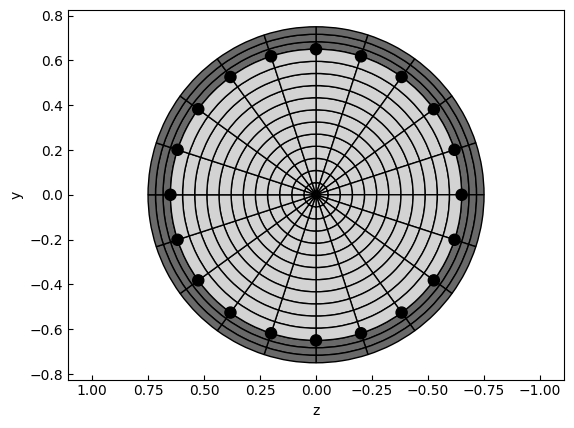

In [29]:
pier_ret = fiber_section(
    section_tag=1,
    diameter=1.5, cover=0.1,
    n_bars=20, rho_s=0.029,
    torsion_GJ=1.5e6,
    mat_core=mat_core, mat_cover=mat_cover, mat_steel=mat_steel,
    mesh_size=None, show_mesh=True, aucuracy_mesh=False, plot_section=True
)

ops.section("Aggregator",2,mat_reverse,"T","-section",1)



#           截面类型   标签 弹性模量 面积 z惯性矩 y惯性矩 剪切模量 扭转惯性矩
ops.section("Elastic", 3,  2.5e7, 10.0, 8.0, 12.0, 9.6e6, 15.0)


## 构建element

In [30]:
def build_pier_elements_nonlin(pier_nodes: list,
                               secTag: int,
                               ele_tag_start: int = 1,
                               np: int = 5,
                               end_node_idx: int = 1):

    pdelta_trans_tag = 1
    ops.geomTransf('PDelta', pdelta_trans_tag, 0.0, 1.0, 0.0)

    linear_trans_tag = 2
    ops.geomTransf('Linear', linear_trans_tag, 0.0, 1.0, 0.0)

    integration_tag = 1
    ops.beamIntegration('Lobatto', integration_tag, secTag, np)

    A_col  = 2.0
    E_col  = 3.0e10
    G_col  = 1.2e10
    J_col  = 0.20
    Iy_col = 0.15
    Iz_col = 0.30

    eTag  = int(ele_tag_start)
    eTags = []

    for pier in pier_nodes:
        for col in pier:
            nNode = len(col)
            bottom_boundary_idx = end_node_idx
            top_boundary_idx    = nNode - 1 - end_node_idx

            # 底部非线性段：用 Linear 变换 + integration_tag=1
            for i in range(bottom_boundary_idx):
                ni, nj = col[i], col[i + 1]
                eTags.append(eTag)
                ops.element('forceBeamColumn', eTag, ni, nj,
                            linear_trans_tag, integration_tag,
                            '-iter', 50, 1.0e-5)
                eTag += 1

            # 中段弹性段：用 PDelta 变换
            for i in range(bottom_boundary_idx, top_boundary_idx):
                ni, nj = col[i], col[i + 1]
                eTags.append(eTag)
                ops.element('elasticBeamColumn', eTag, ni, nj,
                            A_col, E_col, G_col, J_col, Iy_col, Iz_col,
                            linear_trans_tag)
                eTag += 1

            # 顶部非线性段
            for i in range(top_boundary_idx, nNode - 1):
                ni, nj = col[i], col[i + 1]
                eTags.append(eTag)
                ops.element('forceBeamColumn', eTag, ni, nj,
                            linear_trans_tag, integration_tag,
                            '-iter', 50, 1.0e-5)
                eTag += 1

    return eTags



def build_beam_elements_elastic(deck_nodes: list,
                                A: float, E: float, G: float,
                                J: float, Iy: float, Iz: float,
                                ele_tag_start: int = 1000):
    """
    桥面梁：按中心线顺序连接为 elasticBeamColumn。
    几何变换在函数内定义：Linear，参考向量 (0,0,1)。
    返回：下一个可用元素号。
    """
    # 定义/覆盖几何变换
    trans_tag = 3
    ops.geomTransf('Linear', trans_tag, 0.0, 0.0, 1.0)

    # 串接所有跨的节点（生成时已避免跨界重复端点）
    chain = []
    for span in deck_nodes:
        chain.extend(span)

    eTag = int(ele_tag_start)
    eTags =  []
    for i in range(len(chain) - 1):
        eTags.append(eTag)
        ni, nj = chain[i], chain[i+1]
        ops.element('elasticBeamColumn', eTag, ni, nj,
                    A, E, G, J, Iy, Iz, trans_tag)
        eTag += 1
    return eTags

In [31]:
pier_ele = build_pier_elements_nonlin(
    pier_nodes=pier_res["pier_nodes"],
    secTag=2,      # 你的截面号（如纤维截面）
    ele_tag_start=1,
    np=10
)

beam_ele = build_beam_elements_elastic(
    deck_nodes=deck_res["deck_nodes"],
    A=2.0, E=3.0e10, G=1.2e10, J=0.20, Iy=0.15, Iz=0.30,
    ele_tag_start=1000
)

# opsvis.plot_model(show_node_numbering=True)

## 构建横向刚性单元用于连接 桥墩-盖梁

In [32]:
def tie_piers_capbeam(pier_nodes, capbeam_nodes, capbeam_center_nodes):
    """
    1. 将每个盖梁节点与对应盖梁中心节点 rigidLink，模拟刚性盖梁
    2. 将墩顶节点 rigidLink 到盖梁中心节点，保证墩反力传递到主梁支座
    """
    for i, pier in enumerate(pier_nodes):
        center = capbeam_center_nodes[i]
        cb_nodes = capbeam_nodes[i]
        # 盖梁横向节点并到中心
        for n in cb_nodes:
            if n != center:
                ops.rigidLink('beam', center, n)
        # 每根柱顶节点并到中心
        for col in pier:
            top = col[-1]
            ops.rigidLink('beam', center, top)

tie_piers_capbeam(pier_res["pier_nodes"], capbeam_res["capbeam_nodes"], capbeam_res["capbeam_center_nodes"])


### 刚性连接桥台，只在展开桥台时使用

In [33]:
# def rigidify_abutments(left_nodes: list[int], right_nodes: list[int]) -> dict:
#     """
#     将左右两端桥台顶节点各自用 rigidLink('beam', ...) 并为一个刚体。
#     返回 {'left_master': tag, 'right_master': tag}
#     """
#     def _rigidify(group: list[int]) -> int:
#         ys = [ops.nodeCoord(n)[1] for n in group]
#         master = group[min(range(len(group)), key=lambda i: abs(ys[i]))]
#         for n in group:
#             if n != master:
#                 ops.rigidLink('beam', master, n)
#         return master

#     return {
#         'left_master':  _rigidify(left_nodes),
#         'right_master': _rigidify(right_nodes)
#     }
# rigidify_abutments(abut_res["left"],abut_res["right"])


## 处理连接节点

### 桥墩基础foundation

In [34]:
# -*- coding: utf-8 -*-
def set_foundation_linear_springs_min(
    pier_nodes,
    k_trans,                 # 长度=3: (Kx, Ky, Kz)
    k_rot,                   # 长度=3: (Kr_x, Kr_y, Kr_z)
    ele_tag_base,            # 第一个zeroLength元素号
    mat_tag_base,            # 第一个弹簧材料号（将占用连续6个号/根柱）
    ground_node_base         # 第一个“地基节点”号（每根柱占1个）
):
    ele_tag = int(ele_tag_base)
    mat_base = int(mat_tag_base)
    gnode   = int(ground_node_base)

    Kx, Ky, Kz = map(float, k_trans)
    Krx, Kry, Krz = map(float, k_rot)

    for span in pier_nodes:           # k
        for col_nodes in span:        # j
            base_node = int(col_nodes[0])  # 柱底节点（你已按约定把底部放在索引0）
            x, y, z = ops.nodeCoord(base_node)

            # 地基节点：与底节点同坐标并全固结
            ops.node(gnode, x, y, z)
            ops.fix(gnode, 1, 1, 1, 1, 1, 1)

            # 6个单轴线弹簧材料（平移1-3，转动4-6）
            mats = [mat_base + i for i in range(6)]
            ops.uniaxialMaterial('Elastic', mats[0], Kx)
            ops.uniaxialMaterial('Elastic', mats[1], Ky)
            ops.uniaxialMaterial('Elastic', mats[2], Kz)
            ops.uniaxialMaterial('Elastic', mats[3], Krx)
            ops.uniaxialMaterial('Elastic', mats[4], Kry)
            ops.uniaxialMaterial('Elastic', mats[5], Krz)

            # 零长度弹簧单元（6自由度）
            ops.element('zeroLength', ele_tag, base_node, gnode,
                        '-mat', *mats,
                        '-dir', 1, 2, 3, 4, 5, 6)

            # 递增到下一根柱
            ele_tag += 1      # 每根柱1个zeroLength
            mat_base += 6     # 每根柱占6个材料号
            gnode += 1        # 每根柱1个地基节点


k_trans = (4.21875e7, 2.109375e7, 7.5e9)
k_rot   = (4.5e8,    2.25e8,     1.2e8)


set_foundation_linear_springs_min(
    pier_nodes=pier_res["pier_nodes"],
    k_trans=k_trans,
    k_rot=k_rot,
    ele_tag_base=1500,         # 你的zeroLength起始号
    mat_tag_base=2000,        # 你的材料起始号（每根柱占6个）
    ground_node_base=2500     # 你的地基节点起始号（每根柱1个）
)
# opsvis.plot_model(show_node_numbering=True)

### 桥墩支座

In [35]:
def set_bearing(capbeam_center_nodes, deck_nodes, mat_tags, start_ele_tag=2000, tol=1e-6):
    """
    经典支座设置：只在 1,2,3 平动方向设置支座刚度，转动自由度不约束
    mat_tags: (kx, ky, kz)，依次对应 DOF 1, 2, 3 的材料编号
    """
    deck_tags = [dn for row in deck_nodes for dn in row]
    deck_xyz = {dn: ops.nodeCoord(dn) for dn in deck_tags}

    ele = int(start_ele_tag)
    kx, ky, kz = mat_tags

    bearing_eles, mapping = [], []

    for cap_main in capbeam_center_nodes:
        xc, yc, zc = ops.nodeCoord(cap_main)
        # 找最近的主梁节点
        deck_near = min(
            deck_tags,
            key=lambda dn: (deck_xyz[dn][0] - xc) ** 2
                          + (deck_xyz[dn][1] - yc) ** 2
                          + (deck_xyz[dn][2] - zc) ** 2
        )

        # 只在 1,2,3 平动方向给支座刚度，4,5,6 不约束 = 支座处转动自由
        ops.element(
            'zeroLength', ele, deck_near, cap_main,
            '-mat', kx, ky, kz,
            '-dir', 1, 2, 3
        )

        bearing_eles.append(ele)
        mapping.append((cap_main, deck_near))
        ele += 1

    return {"bearing_eles": bearing_eles, "map": mapping}


    
bear_res = set_bearing(capbeam_res["capbeam_center_nodes"],deck_res["deck_nodes"],mat_tags=(4,5,6))
# opsvis.plot_model(show_node_numbering=True)

### 桥台

In [36]:

def set_abutment(
    deck_nodes,
    start_node_tag,
    start_ele_tag,
    ssi_mat_tags, ssi_dirs,          # 桥台-地基：土弹簧
    bearing_mat_tags, bearing_dirs,  # 主梁-桥台：支座
    contact_mat_tags, contact_dirs,  # 主梁-桥台：碰撞/限位
    shearkey_mat_tags, shearkey_dirs,# 主梁-桥台：剪力键
    x_tol=1e-9
):
    # 识别首尾主梁节点：x最小和x最大；若同x取|y|最小
    tags = [n for row in deck_nodes for n in row]
    xyz  = {n: ops.nodeCoord(n) for n in tags}
    left  = min(tags, key=lambda n: (xyz[n][0],  abs(xyz[n][1])))
    right = max(tags, key=lambda n: (xyz[n][0], -abs(xyz[n][1])))


    tnode = int(start_node_tag)
    tele  = int(start_ele_tag)

    res = {
        "deck_end_nodes": {"left": left, "right": right},
        "abutment_nodes": {},     # 桥台节点
        "foundation_nodes": {},   # 地基节点
        "ssi_elements": [],       # 桥台-地基
        "bearing_elements": [],   # 主梁-桥台 支座
        "contact_elements": [],   # 主梁-桥台 碰撞
        "shearkey_elements": []   # 主梁-桥台 剪力键
    }

    for side, dn in (("left", left), ("right", right)):
        x, y, z = xyz[dn]

        abut = tnode; tnode += 1
        base = tnode; tnode += 1
        ops.node(abut, x, y, z)
        ops.node(base, x, y, z)
        ops.fix(base, 1, 1, 1, 1, 1, 1)

        # 桥台-地基：SSI
        ops.element('zeroLength', tele, abut, base,
                    '-mat', *ssi_mat_tags, '-dir', *ssi_dirs)
        res["ssi_elements"].append(tele); tele += 1

        # 主梁-桥台：支座
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *bearing_mat_tags, '-dir', *bearing_dirs)
        res["bearing_elements"].append(tele); tele += 1

        # 主梁-桥台：碰撞/限位
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *contact_mat_tags, '-dir', *contact_dirs)
        res["contact_elements"].append(tele); tele += 1

        # 主梁-桥台：剪力键
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *shearkey_mat_tags, '-dir', *shearkey_dirs)
        res["shearkey_elements"].append(tele); tele += 1

        res["abutment_nodes"][side] = abut
        res["foundation_nodes"][side] = base

    return res


abutment_res = set_abutment(deck_nodes = deck_res["deck_nodes"],
                            start_node_tag = 5000,
                            start_ele_tag  = 5000,
                            ssi_mat_tags = (7,), ssi_dirs = (1,),          # 桥台-地基：土弹簧
                            bearing_mat_tags = (4,5,6), bearing_dirs = (1,2,3),  # 主梁-桥台：支座
                            contact_mat_tags = (8,), contact_dirs = (1,),  # 主梁-桥台：碰撞/限位
                            shearkey_mat_tags = (9,), shearkey_dirs = (2,),# 主梁-桥台：剪力键
                            x_tol=1e-9
                            )

# opsvis.plot_model(show_node_numbering=True)

# 桥台节点需提供转动约束，否则zeroLength支座不控制4-6自由度会引发奇异矩阵
for abut_tag in abutment_res["abutment_nodes"].values():
    ops.fix(abut_tag, 0, 0, 0, 1, 1, 1)


## 施加质量

In [37]:

def assign_mass_from_elements(ele_tags, rho, area, dofs=(1, 2, 3)):
    """
    根据一组梁单元，按密度和截面面积自动给节点分配质量

    ele_tags : 主梁元素编号列表，例如 [101, 102, ...]
    rho      : 材料密度（单位自己控制，比如 kg/m3）
    area     : 可以是一个统一的 float，或者 dict{eleTag: A}
    dofs     : 哪些自由度分配质量，3D 一般是 (1,2,3) 三个平动方向
    """
    # 1. 统计各节点从这些梁得到的“标量质量” m
    node_mass_scalar = {}

    for ele in ele_tags:
        # 元素端节点
        ele_nodes = ops.eleNodes(ele)  # [iNode, jNode]
        if len(ele_nodes) < 2:
            continue
        ni, nj = ele_nodes[0], ele_nodes[-1]

        # 节点坐标
        xi, yi, zi = ops.nodeCoord(ni)
        xj, yj, zj = ops.nodeCoord(nj)

        # 元素长度
        L = math.sqrt((xj - xi) ** 2 + (yj - yi) ** 2 + (zj - zi) ** 2)

        # 面积 A：可以统一一个值，也可以按元素给字典
        if isinstance(area, dict):
            A = area[ele]
        else:
            A = area

        # 元素总质量
        m_ele = rho * A * L

        # 平均分到两端节点
        m_node = 0.5 * m_ele

        for nd in (ni, nj):
            node_mass_scalar[nd] = node_mass_scalar.get(nd, 0.0) + m_node

    # 2. 把标量质量写入 OpenSees，各平动自由度都加上这个质量
    for nd, m in node_mass_scalar.items():
        # 读取节点当前质量（可能为空）
        old = ops.nodeMass(nd)
        if old is None or len(old) == 0:
            # 假定 6 自由度模型（你现在用的 ndm=3, ndf=6）
            mass_vals = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
            mass_vals = list(old)

        # 在指定自由度上增加质量
        for dof in dofs:
            idx = dof - 1
            # 防止旧长度不够
            if idx >= len(mass_vals):
                mass_vals.extend([0.0] * (idx + 1 - len(mass_vals)))
            mass_vals[idx] += m

        # 写回质量
        ops.mass(nd, *mass_vals)

    # 返回一个节点-标量质量字典，方便后面施加重力
    return node_mass_scalar



def assign_capbeam_lumped_mass(capbeam_nodes, capbeam_center_nodes,
                               rho, area, dofs=(1, 2, 3)):
    """
    给只有 rigidLink 的盖梁集中质量到中心节点

    capbeam_nodes        : 二维列表，每个元素是一墩的盖梁节点列表 [[n1,n2,...], [..], ...]
    capbeam_center_nodes : 一维列表，每墩的盖梁中心节点 [c1, c2, ...]
    rho                  : 盖梁混凝土密度
    area                 : 盖梁截面面积（统一一个值）
    dofs                 : 分配质量的自由度，一般 (1,2,3) 三个平动
    """
    node_mass_scalar = {}

    for i, nodes_i in enumerate(capbeam_nodes):
        if not nodes_i:
            continue

        # 盖梁长度：按 y 方向跨度估算
        ys = [ops.nodeCoord(n)[1] for n in nodes_i]
        L_i = max(ys) - min(ys)

        # 这一跨盖梁总质量
        m_i = rho * area * L_i

        # 集中到盖梁中心节点
        nd_center = capbeam_center_nodes[i]
        node_mass_scalar[nd_center] = node_mass_scalar.get(nd_center, 0.0) + m_i

    # 写入 OpenSees 的质量（集中到中心节点）
    for nd, m in node_mass_scalar.items():
        old = ops.nodeMass(nd)
        if old is None or len(old) == 0:
            mass_vals = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        else:
            mass_vals = list(old)

        for dof in dofs:
            idx = dof - 1
            if idx >= len(mass_vals):
                mass_vals.extend([0.0] * (idx + 1 - len(mass_vals)))
            mass_vals[idx] += m

        ops.mass(nd, *mass_vals)

    return node_mass_scalar



In [38]:
beam_mass = assign_mass_from_elements(beam_ele,2.5,20)
pier_mass = assign_mass_from_elements(pier_ele,2.5,1.77)
capbeam_mass = assign_capbeam_lumped_mass(capbeam_res["capbeam_nodes"],capbeam_res["capbeam_center_nodes"],1,5)


## 重力静力分析

In [39]:
def merge_mass(target, source):
    for nd, m in source.items():
        target[nd] = target.get(nd, 0.0) + m

def run_gravity_analysis(total_mass, g=9.81):
    """
    根据 total_mass 字典施加自重，做一遍重力静力分析并固结。
    total_mass: {nodeTag: 标量质量}，单位和前面 assign_mass_from_elements 一致
    g         : 重力加速度，默认 9.81
    """
    # 清理旧的分析设置，但不动模型
    ops.wipeAnalysis()

    # 定义重力荷载的 timeSeries 和 pattern
    ts_tag = 1
    pat_tag = 1
    ops.timeSeries("Linear", ts_tag)
    ops.pattern("Plain", pat_tag, ts_tag)

    # 把质量转成结点竖向荷载：Fz = -m * g
    # 竖向为第 3 个自由度，向下为负号
    for nd, m in total_mass.items():
        ops.load(nd, 0.0, 0.0, -m * g, 0.0, 0.0, 0.0)

    # 设置静力分析器
    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.system("BandGeneral")
    ops.test("NormDispIncr", 1.0e-6, 100)
    ops.algorithm("NewtonLineSearch", "Bisection")

    # 100 步把重力从 0 加到 1，步长 = 1/100
    ops.integrator("LoadControl", 1.0 / 100.0)
    ops.analysis("Static")
    status = ops.analyze(100)

    # 固结当前重力状态
    ops.loadConst("-time", 0.0)

    return status

total_mass = {}
merge_mass(total_mass, beam_mass)
merge_mass(total_mass, pier_mass)
merge_mass(total_mass, capbeam_mass)

gravity_status = run_gravity_analysis(total_mass)
print(f"Gravity analysis status: {gravity_status}")  # 0 indicates success


Gravity analysis status: 0


## 设置阻尼

In [40]:
# 计算自振周期与设置 Rayleigh 阻尼
def get_periods(nMode=3):
    ops.wipeAnalysis()
    ops.system('BandGeneral')
    ops.numberer('RCM')
    ops.constraints('Transformation')
    lambdas = ops.eigen(nMode)
    periods = []
    for lam in lambdas:
        if lam is None or lam <= 0.0:
            periods.append(None)
        else:
            omega = math.sqrt(lam)
            periods.append(2.0 * math.pi / omega)
    return periods

def set_rayleigh_damping_by_T(T1, T2, xi):
    w1 = 2.0 * math.pi / T1
    w2 = 2.0 * math.pi / T2
    alphaM = 2.0 * xi * w1 * w2 / (w1 + w2)
    betaK = 2.0 * xi / (w1 + w2)
    ops.rayleigh(alphaM, 0.0, betaK, 0.0)
    return alphaM, betaK

def configure_default_rayleigh(xi=0.05, nMode=6):
    # 多求几个振型，防止前面有刚体模态
    Ts = get_periods(nMode)

    # 只保留真正有意义的周期
    valid_T = [T for T in Ts if (T is not None) and (T > 0.0)]

    if len(valid_T) < 2:
        raise RuntimeError('振型中有效周期不足 2 个，无法设置 Rayleigh 阻尼')

    T1, T2 = valid_T[0], valid_T[1]

    w1 = 2.0 * math.pi / T1
    w2 = 2.0 * math.pi / T2
    alphaM = 2.0 * xi * w1 * w2 / (w1 + w2)
    betaK  = 2.0 * xi / (w1 + w2)
    ops.rayleigh(alphaM, 0.0, betaK, 0.0)
    print(f"Rayleigh damping applied with T1={T1:.3f}s, T2={T2:.3f}s, xi={xi}")
    return {"periods": Ts, "alphaM": alphaM, "betaK": betaK}


rayleigh_info = configure_default_rayleigh()


Rayleigh damping applied with T1=0.951s, T2=0.549s, xi=0.05


# 重建整个桥梁模型并完成重力分析，返回关键节点/单元信息。

In [41]:
def rebuild_model_with_gravity():
    """重建整个桥梁模型并完成重力分析，返回关键节点/单元信息。"""
    ops.wipe()
    ops.model('basic', '-ndm', 3, '-ndf', 6)
    units = {"length": "m", "force": "N", "mass": "kg"}

    pier_res = define_pier_nodes(num_spans=num_spans,
                                 span_length=span_length,
                                 cols_per_pier=cols_per_pier,
                                 nodes_per_col=nodes_per_col,
                                 col_height=col_height,
                                 deck_width=deck_width,
                                 edge_clear=edge_clear)

    deck_res = define_deck_nodes(num_spans=num_spans,
                                 span_length=span_length,
                                 nodes_per_span=nodes_per_span,
                                 col_height=col_height)

    capbeam_res = define_capbeam_nodes(pier_res["pier_nodes"])
    # for center_tag in capbeam_res["capbeam_center_nodes"]:
    #     ops.fix(center_tag, 0, 0, 0, 1, 1, 1)

    # 材料
    ops.uniaxialMaterial('Concrete02', mat_core,  -40e6, -0.0025, -25e6, -0.02, 0.1, 2.0e6, 200e6)
    ops.uniaxialMaterial('Concrete02', mat_cover, -30e6, -0.0020, -20e6, -0.0035, 0.1, 1.5e6, 150e6)
    ops.uniaxialMaterial('Steel02',    mat_steel, 420e6, 2.0e11, 0.01, 20.0, 0.925, 0.15)
    ops.uniaxialMaterial('Elastic',    mat_bearing_ver, 2.0e8)
    ops.uniaxialMaterial('ElasticPP',  mat_bearing_tran, 2.0e5 , 0.002)
    ops.uniaxialMaterial('Elastic',    mat_reverse, 1.0e9)
    ops.uniaxialMaterial('ElasticPPGap', mat_soil, 5.0e4, -5000.0, -0.03)
    ops.uniaxialMaterial('ElasticPPGap', mat_deck_abut, 1.0e7, -1.0e8, -0.05)
    ops.uniaxialMaterial('ElasticPPGap', shear_key,  2.0e8, 6.0e5, 0.02)

    fiber_section(
        section_tag=1,
        diameter=1.5, cover=0.1,
        n_bars=20, rho_s=0.029,
        torsion_GJ=1.5e6,
        mat_core=mat_core, mat_cover=mat_cover, mat_steel=mat_steel,
        mesh_size=None, show_mesh=False, aucuracy_mesh=False, plot_section=False
    )

    ops.section("Aggregator", 2, mat_reverse, "T", "-section", 1)
    ops.section("Elastic", 3,  2.5e7, 10.0, 8.0, 12.0, 9.6e6, 15.0)

    pier_ele = build_pier_elements_nonlin(
        pier_nodes=pier_res["pier_nodes"],
        secTag=2,
        ele_tag_start=1,
        np=7
    )

    beam_ele = build_beam_elements_elastic(
        deck_nodes=deck_res["deck_nodes"],
        A=2.0, E=3.0e10, G=1.2e10, J=0.20, Iy=0.15, Iz=0.30,
        ele_tag_start=1000
    )

    tie_piers_capbeam(pier_res["pier_nodes"], capbeam_res["capbeam_nodes"], capbeam_res["capbeam_center_nodes"])
    k_trans = (1.0e7, 1.0e7, 8.0e8)
    k_rot   = (2.0e8, 2.0e8, 1.0e8)

    # k_trans = (274774.0045, 274774.0045, 1.0e7)
    # k_rot   = (1371958.6382, 1152445.2561, 1.0e8)


    set_foundation_linear_springs_min(
        pier_nodes=pier_res["pier_nodes"],
        k_trans=k_trans,
        k_rot=k_rot,
        ele_tag_base=1500,
        mat_tag_base=2000,
        ground_node_base=2500
    )

    bear_res = set_bearing(capbeam_res["capbeam_center_nodes"], deck_res["deck_nodes"], mat_tags=(4,5,6))

    abutment_res = set_abutment(deck_nodes=deck_res["deck_nodes"],
                                start_node_tag=5000,
                                start_ele_tag=5000,
                                ssi_mat_tags=(7,), ssi_dirs=(1,),
                                bearing_mat_tags=(4,5,6), bearing_dirs=(1,2,3),
                                contact_mat_tags=(8,), contact_dirs=(1,),
                                shearkey_mat_tags=(9,), shearkey_dirs=(2,),
                                x_tol=1e-9)
    for abut_tag in abutment_res["abutment_nodes"].values():
        ops.fix(abut_tag, 0, 0, 0, 1, 1, 1)

    beam_mass = assign_mass_from_elements(beam_ele, 2700, 4)
    pier_mass = assign_mass_from_elements(pier_ele, 2700, 2)
    capbeam_mass = assign_capbeam_lumped_mass(capbeam_res["capbeam_nodes"], capbeam_res["capbeam_center_nodes"], 2700,0.6)

    total_mass = {}
    merge_mass(total_mass, beam_mass)
    merge_mass(total_mass, pier_mass)
    merge_mass(total_mass, capbeam_mass)

    status = run_gravity_analysis(total_mass)
    if status != 0:
        raise RuntimeError(f'重力分析失败')

    damping_info = configure_default_rayleigh()

    return {
        "pier_res": pier_res,
        "deck_res": deck_res,
        "capbeam_res": capbeam_res,
        "bear_res": bear_res,
        "abutment_res": abutment_res,
        "pier_ele": pier_ele,
        "beam_ele": beam_ele,
        "beam_mass": beam_mass,
        "pier_mass": pier_mass,
        "capbeam_mass": capbeam_mass,
        "units": units,
        "damping": damping_info
    }


In [42]:
import numpy as np
from pathlib import Path

def apply_uniform_gm_from_txt(file_path, ts_tag=200, pattern_tag=200, dof=1, factor=9.8):
    """
    从 txt 文件加载地震动并建立 Path timeSeries + UniformExcitation。
    返回包含时间序列信息的字典，便于确定积分步长。
    """
    data = np.loadtxt(file_path)
    t = np.array(data[:, 0], dtype=float)
    acc = np.array(data[:, 1], dtype=float) * float(factor)

    # 时间轴归一到从 0 开始
    if t[0] != 0.0:
        t = t - t[0]

    # 总时长（秒）
    tFinal = float(t[-1])

    ops.timeSeries('Path', ts_tag,
                   '-time', *t.tolist(),
                   '-values', *acc.tolist())
    ops.pattern('UniformExcitation', pattern_tag, dof,
                '-accel', ts_tag)

    return {"time": t, "acc": acc, "tFinal": tFinal}


## 执行分析

In [43]:
def setup_default_recorders(output_dir, pier_res, bear_res, abutment_res):
    """按既定节点/单元记录响应，输出到指定文件夹。"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    pier_nodes_to_rec = [
        pier_res["pier_nodes"][i][j][-1]
        for i in range(len(pier_res["pier_nodes"]))
        for j in range(len(pier_res["pier_nodes"][i]))
    ]
    bearing_cap_nodes = [pair[0] for pair in bear_res["map"]]
    bearing_deck_nodes = [pair[1] for pair in bear_res["map"]]
    bearing_eles = bear_res["bearing_eles"]
    abutment_nodes_to_rec = [
        abutment_res["abutment_nodes"]["left"],
        abutment_res["abutment_nodes"]["right"]
    ]

    ops.remove('recorders')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_pier_top_disp.out'),
                 '-time',
                 '-node', *pier_nodes_to_rec,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_bearing_cap_disp.out'),
                 '-time',
                 '-node', *bearing_cap_nodes,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_bearing_deck_disp.out'),
                 '-time',
                 '-node', *bearing_deck_nodes,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Element',
                 '-file', str(output_dir / 'rec_bearing_def.out'),
                 '-time',
                 '-ele', *bearing_eles,
                 'deformations')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_abutment_disp.out'),
                 '-time',
                 '-node', *abutment_nodes_to_rec,
                 '-dof', 1, 2, 3,
                 'disp')


In [44]:
import csv
import shutil
def run_ground_motion_batch(gm_folder, results_root=Path('results'), dof=1, factor=9.8):
    gm_folder = Path(gm_folder)
    results_root = Path(results_root)

    # 清空结果目录
    for item in results_root.iterdir():
        if item.is_file():
            item.unlink()
        elif item.is_dir():
            shutil.rmtree(item)
    results_root.mkdir(parents=True, exist_ok=True)

    gm_files = sorted(gm_folder.glob('*.txt'))
    summary = []

    for idx, gm_file in enumerate(gm_files, start=1):
        print(f"[{idx}/{len(gm_files)}] 处理 {gm_file.name}")
        gm_tag = 2000 + idx
        run_info = {
            'gm_name': gm_file.name,
            'status': 'pending',
            'steps_completed': 0,
            'message': ''
        }

        try:
            model_ctx = rebuild_model_with_gravity()
            gm_info = apply_uniform_gm_from_txt(
                str(gm_file),
                ts_tag=gm_tag,
                pattern_tag=gm_tag,
                dof=dof,
                factor=factor
            )

            out_dir = results_root / gm_file.stem
            setup_default_recorders(
                out_dir,
                model_ctx['pier_res'],
                model_ctx['bear_res'],
                model_ctx['abutment_res']
            )

            ops.wipeAnalysis()
            ops.constraints('Transformation')
            ops.numberer('RCM')
            ops.system('BandGeneral')

            # 全局收敛标准稍微放宽一点，给非线性留点空间
            ops.test('NormDispIncr', 1.0e-4, 50)
            ops.algorithm('NewtonLineSearch', '-type', 'Bisection')
            ops.integrator('Newmark', 0.5, 0.25)
            ops.analysis('Transient')

            tFinal = gm_info['tFinal']
            base_dt = 0.002      # 你原来的时间步
            dt_min  = 0.00025    # 最小允许时间步
            t_now   = 0.0
            step_ok = 0
            ok      = 0

            while t_now < tFinal:
                ok = ops.analyze(1, base_dt)
                if ok == 0:
                    # 正常通过这一小步
                    t_now += base_dt
                    step_ok += 1
                    continue

                # 如果这一小步不收敛，自动把步长减半重试
                dt_try = base_dt / 2.0
                retry_ok = 0
                while dt_try >= dt_min:
                    retry_ok = ops.analyze(1, dt_try)
                    if retry_ok == 0:
                        t_now += dt_try
                        step_ok += 1
                        break
                    dt_try /= 2.0

                if retry_ok != 0:
                    # 缩到 dt_min 还是过不去，就认为在这一时刻结构已经
                    # 深入到求解器控制不了的状态，提前退出
                    ok = -3
                    break



        except Exception as exc:
            run_info['status'] = 'error'
            run_info['message'] = str(exc)

        finally:
            # 统一清理，不管成功还是异常
            try:
                ops.remove('recorders')
                ops.remove('loadPattern', gm_tag)
                ops.remove('timeSeries', gm_tag)
            except Exception:
                pass

        summary.append(run_info)

    summary_file = results_root / 'batch_summary.csv'
    with summary_file.open('w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=['gm_name', 'status', 'steps_completed', 'message']
        )
        writer.writeheader()
        writer.writerows(summary)

    return summary


GM_DIR = Path(r"../GM_process/ground_motions/scalared_data/test")
RESULT_ROOT = Path('results')
RESULT_ROOT.mkdir(exist_ok=True)
batch_summary = run_ground_motion_batch(GM_DIR, RESULT_ROOT, dof=1, factor=9.8)
print('Batch summary写入:', RESULT_ROOT / 'batch_summary.csv')


[1/3] 处理 RSN10_IMPVALL.BG_C-ELC090.txt
Rayleigh damping applied with T1=14.014s, T2=8.092s, xi=0.05


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 1(dW: << 1.58838e-05, dW0: 1.10102e-05)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 8(dW: << 1.58838e-05, dW0: 1.10102e-05)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 15(dW: << 1.58838e-05, dW0: 1.10102e-05)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 22(dW: << 1.58838e-05, dW0: 1.10102e-05)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.696
OpenSees > analyze failed, returned: -3 error flag
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 1(dW: << 0.000

[2/3] 处理 RSN6_IMPVALL.I_I-ELC180.txt
Rayleigh damping applied with T1=14.014s, T2=8.092s, xi=0.05


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 1(dW: << 0.566265, dW0: 13.3133)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 8(dW: << 0.566265, dW0: 13.3133)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 15(dW: << 0.566265, dW0: 13.3133)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 22(dW: << 0.566265, dW0: 13.3133)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 3.55
OpenSees > analyze failed, returned: -3 error flag
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 1(dW: << 0.566265, dW0: 2.93357)
WARNING - 

[3/3] 处理 RSN9_BORREGO_B-ELC090.txt
Rayleigh damping applied with T1=14.014s, T2=8.092s, xi=0.05


WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 129
WARNING NewtonLineSearch::solveCurrentStep() -the LinearSysOfEqn failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.054
OpenSees > analyze failed, returned: -3 error flag
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 129
WARNING NewtonLineSearch::solveCurrentStep() -the LinearSysOfEqn failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.055
OpenSees > analyze failed, returned: -3 error flag
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 129
WARNING NewtonLineSearch::solveCurrentStep() -the LinearSysOfEqn failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.056
OpenSees > analyze failed, returned: -3 error flag
WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i

KeyboardInterrupt: 